In [21]:
# Import required packages
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] ="false"
import jax
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
import matplotlib


In [22]:
from learning.agents.sampler_ppo.distributions import make_doraemon_update_fn
seed = 1
rng = jax.random.PRNGKey(seed)
key_sample, rng_params, rng = jax.random.split(rng, 3)
# # Use it
# dr_low = jnp.asarray([-10,-5])
# dr_high = jnp.asarray([5,5])



Saved GIF to adr_training.gif


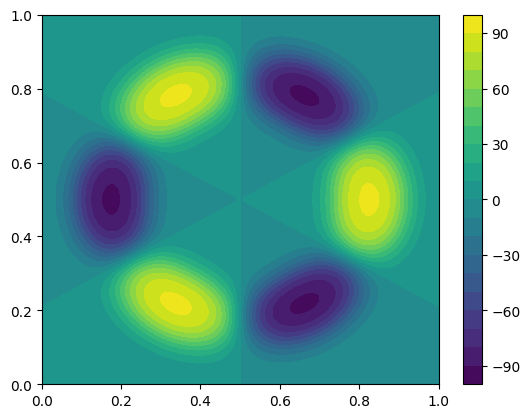

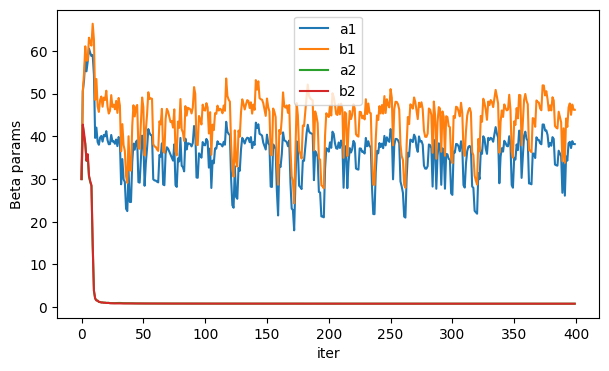

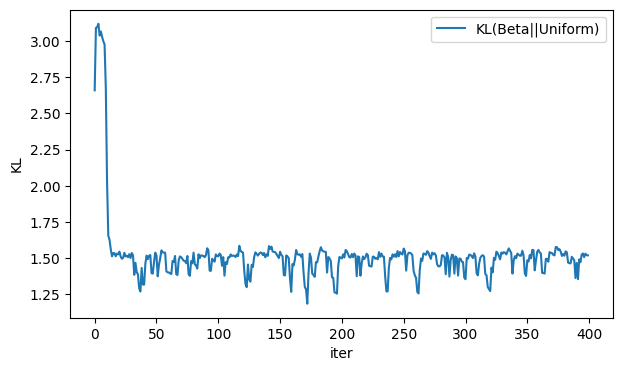

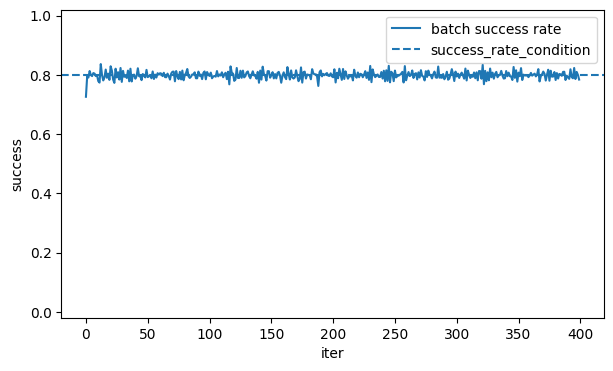

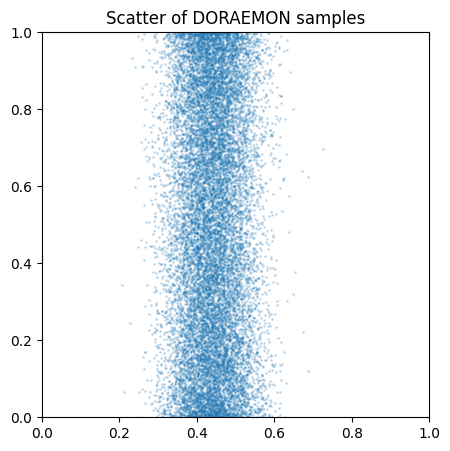

In [23]:
import jax, jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import imageio
from learning.agents.sampler_ppo.distributions import _kl_beta_beta, _unpack_beta, make_initial_state, plot_beta_density_2d

def sample_beta_on_box(key, a, b, low, high, n):
    dim = a.shape[0]
    keys = jax.random.split(key, dim * 2)
    g1 = jnp.stack([jax.random.gamma(keys[i], a[i], shape=(n,)) for i in range(dim)], axis=-1)
    g2 = jnp.stack([jax.random.gamma(keys[i+dim], b[i], shape=(n,)) for i in range(dim)], axis=-1)
    z = g1 / (g1 + g2 + 1e-12)
    return low + (high - low) * z

def reward_corner(contexts, target=jnp.array([0.3, 0.7]), sigma=0.12, noise_std=0.2, key=None):
    # reward in [0,1], peaked near target
    diff = contexts - target[None, :]
    r = jnp.exp(-0.5 * jnp.sum((diff / sigma) ** 2, axis=-1))
    if key is not None:
        r = jnp.clip(r + noise_std * jax.random.normal(key, r.shape), 0.0, 1.0)
    return r
beta=-100
def target3(z):
    m=3
    r0=0.65
    sr=0.12
    X, Y = jnp.split(z, 2, axis=-1)
    x = 2.0 * (X - 0.5)
    y = 2.0 * (Y - 0.5)
    r = jnp.hypot(x, y)
    theta = jnp.arctan2(y, x)

    ring = jnp.exp(-0.5 * ((r - r0) / sr) ** 2)
    petals = jnp.cos(m * theta)
    U = jnp.tanh(1.6 * (ring * petals))  # bounded in (-1, 1)
    log_unnorm = -beta * U.squeeze() 
    # --- 3. Combine ---
    return log_unnorm
    # return jax.nn.log_softmax(log_unnorm) #+ log_prior
low  = jnp.array([0.0, 0.0])
high = jnp.array([1.0, 1.0])
def run_toy_corner():


    # --- DORAEMON knobs (these matter a lot) ---
    success_threshold      = -0.01   # reward >= this => success
    success_rate_condition = 0.80   # constraint target
    kl_upper_bound         = 0.80   # trust region KL(center || proposed)

    min_bound = 0.8
    max_bound = 110.0
    init_beta_param = 30.0

    update_fn = make_doraemon_update_fn(
        low=low, high=high,
        success_threshold=success_threshold,
        success_rate_condition=success_rate_condition,
        kl_upper_bound=kl_upper_bound,
        min_bound=min_bound,
        max_bound=max_bound,
        train_until_performance_lb=False,   # just update every iter for toy
        hard_performance_constraint=True,
        n_steps_main=35,
        n_steps_restore=35,
        step_size_main=0.35,
        step_size_restore=0.35,
    )
    update_fn = jax.jit(update_fn)

    state = make_initial_state(2, init_beta_param, min_bound, max_bound)
    x, y = jnp.meshgrid(jnp.linspace(low[0], high[0], 100), jnp.linspace(low[1], high[1], 100))
    grid = jnp.c_[x.ravel(), y.ravel()]
    pdf_values = reward_corner(grid)
    pdf_values = target3(grid)
    pdf_values = jnp.reshape(pdf_values, x.shape)
    T = 400
    N = 2048
    snap_iters = [0, 1, 2, 5, 10, 15, 24] + list(range(30, T, 100))

    a_hist, b_hist, kl_hist, succ_hist = [], [], [], []
    key = jax.random.PRNGKey(0)
    gif_frames = []
    for t in range(T):
        key, kx, kn = jax.random.split(key, 3)
        a, b = _unpack_beta(state.x_opt, 2, min_bound, max_bound)

        contexts = sample_beta_on_box(kx, a, b, low, high, N)
        returns  = reward_corner(contexts, key=kn)
        returns  = target3(contexts)
        succ = jnp.mean((returns >= success_threshold).astype(jnp.float32))
        kl   = _kl_beta_beta(a, b, jnp.ones_like(a), jnp.ones_like(b))  # KL(Beta||Uniform)

        a_hist.append(np.array(a))
        b_hist.append(np.array(b))
        kl_hist.append(float(kl))
        succ_hist.append(float(succ))

        if t in snap_iters:
            fig, (ax_reward, ax_doraemon) = plt.subplots(1, 2, figsize=(10, 4))
            ctf = ax_reward.contourf(x, y, pdf_values, levels=20)
            ax_reward.set_title("target landscape")
            ax_reward.set_xlabel("context dim 1")
            ax_reward.set_ylabel("context dim 2")
            fig.colorbar(ctf, ax=ax_reward, label="reward")
            ax_doraemon = plot_beta_density_2d(
                state, low, high, len(low), min_bound, max_bound,
                contexts=contexts, returns=returns, success_threshold=success_threshold,
                ax=ax_doraemon,
                title=f"iter {t} | succ={float(succ):.2f} | KL={float(kl):.2f} | a={np.array(a)} b={np.array(b)}"
            )

            ax_doraemon.set_title(f"DORAEMON training distribution (iter {t})")
            fig.tight_layout()
            fig.canvas.draw()
            frame = np.asarray(fig.canvas.buffer_rgba())[..., :3]
            gif_frames.append(frame)
            plt.close(fig)

        state = update_fn(state, contexts, returns)

    a_hist = np.stack(a_hist); b_hist = np.stack(b_hist)
    if gif_frames:
        imageio.mimsave("doraemon_training.gif", gif_frames, fps=4)
        print("Saved GIF to adr_training.gif")
    # Parameter trajectories
    it = np.arange(T)
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(it, a_hist[:,0], label="a1"); ax.plot(it, b_hist[:,0], label="b1")
    ax.plot(it, a_hist[:,1], label="a2"); ax.plot(it, b_hist[:,1], label="b2")
    ax.set_xlabel("iter"); ax.set_ylabel("Beta params")
    ax.legend(); plt.show()

    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(it, kl_hist, label="KL(Beta||Uniform)")
    ax.set_xlabel("iter"); ax.set_ylabel("KL"); ax.legend(); plt.show()

    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(it, succ_hist, label="batch success rate")
    ax.axhline(success_rate_condition, linestyle="--", label="success_rate_condition")
    ax.set_xlabel("iter"); ax.set_ylabel("success"); ax.set_ylim(-0.02, 1.02)
    ax.legend(); plt.show()

    key = jax.random.PRNGKey(0)
    a, b = _unpack_beta(state.x_opt, 2, min_bound, max_bound)
    contexts = sample_beta_on_box(kx, a, b, low, high, 2**14)
    x_np = np.array(contexts)
    np.save(f"doraemon_samples_beta={beta}.npy", x_np)
    # 1) Raw scatter plot (no binning)
    plt.figure(figsize=(5, 5))
    plt.scatter(x_np[:, 0], x_np[:, 1], s=1, alpha=0.2)
    plt.xlim(low[0], high[0])
    plt.ylim(low[1], high[1])
    plt.title("Scatter of DORAEMON samples")
    plt.savefig(f"DORAEMON_image_beta={beta}.png")
    plt.show()
    

x, y = jnp.meshgrid(jnp.linspace(low[0], high[0], 100), jnp.linspace(low[1], high[1], 100))
grid = jnp.c_[x.ravel(), y.ravel()]
pdf_values = reward_corner(grid)
pdf_values = target3(grid)
pdf_values = jnp.reshape(pdf_values, x.shape)
fig = plt.figure()
ctf = plt.contourf(x, y, pdf_values, levels=20, cmap='viridis')
cbar = fig.colorbar(ctf)
run_toy_corner()


In [24]:
pdf_values.max()

Array(92.13237, dtype=float32)